# NLP Externship | Generative LLM - Exploratory Data Analysis

## Introduction
Improved training set quality by pre-processing and normalizing raw text data.
- Removed html tags from text data using BeautifulSoup
- Merged question, answer and tag datasets
- Conducted EDA to identify thresholds for Q&A scores and word/character counts to improve data for modeling
    - Filtered the data to exclude rows with an answer score < 3, maintaining the top 25% of the data
    - Filtered to keep the highest scored answer per question
    - Filtered out answers and questions with word count > 150 or character count > 3K

## Initialization

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

## Load Data

In [ ]:
answers = pd.read_csv('/content/drive/MyDrive/TripleTen/Externship_Dataspark/Datasets/python_Q_A/Answers.csv', encoding='latin-1')
questions = pd.read_csv('/content/drive/MyDrive/TripleTen/Externship_Dataspark/Datasets/python_Q_A/Questions.csv', encoding='latin-1')
tags = pd.read_csv('/content/drive/MyDrive/TripleTen/Externship_Dataspark/Datasets/python_Q_A/Tags.csv', encoding='latin-1')

In [ ]:
# Create function to remove html elements from data
def extract_data_from_report3(filename):
    soup = BeautifulSoup(open(filename), "html.parser")

extract_data_from_report3

<function __main__.extract_data_from_report3(filename)>

In [ ]:
questions.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [ ]:
answers.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B..."


In [ ]:
tags.head()

,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


In [ ]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607282 entries, 0 to 607281
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Id            607282 non-null  int64  
 1   OwnerUserId   601070 non-null  float64
 2   CreationDate  607282 non-null  object 
 3   Score         607282 non-null  int64  
 4   Title         607282 non-null  object 
 5   Body          607282 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 27.8+ MB


In [ ]:
answers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987122 entries, 0 to 987121
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Id            987122 non-null  int64  
 1   OwnerUserId   981755 non-null  float64
 2   CreationDate  987122 non-null  object 
 3   ParentId      987122 non-null  int64  
 4   Score         987122 non-null  int64  
 5   Body          987122 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 45.2+ MB


### Initial pre-processing

In [ ]:
# Convert column names to lowercase
answers.columns = answers.columns.str.lower()
questions.columns = questions.columns.str.lower()
tags.columns = tags.columns.str.lower()

In [ ]:
# Convert data types
questions.creationdate = pd.to_datetime(questions.creationdate)
answers.creationdate = pd.to_datetime(answers.creationdate)

In [ ]:
# Number of unique questions
questions['id'].nunique()

607282

In [ ]:
# Number of unique tags
print(tags['id'].nunique())
tags = tags.dropna()
print(tags['id'].nunique())

607283
607283


In [ ]:
tags['tag'].value_counts()[:10]

python        607283
django         62818
python-2.7     34616
pandas         26854
python-3.x     26814
numpy          25848
list           18951
matplotlib     16521
regex          14047
dictionary     13413
Name: tag, dtype: int64

- 'Python' is a tag in every record, so it can be dropped

In [ ]:
# Remove any python tags
tags = tags[~tags['tag'].str.contains('python')]

In [ ]:
# List of top 10 tags
tags['tag'].value_counts()[:10]

django        62818
pandas        26854
numpy         25848
list          18951
matplotlib    16521
regex         14047
dictionary    13413
tkinter       10766
string        10616
flask         10488
Name: tag, dtype: int64

In [ ]:
# Combine tags into one column per question
tags = tags.groupby('id').agg(', '.join)
tags.head()

,tag
id,
469,"osx, fonts, photoshop"
502,"windows, image, pdf"
535,"continuous-integration, extreme-programming"
594,"sql, database, oracle, cx-oracle"
683,"arrays, iteration"


In [ ]:
# Join quesitons, answers and tags for each question
df = questions.merge(answers, left_on='id', right_on='parentid', how='outer', suffixes=['_q', '_a'])
df = df.merge(tags, left_on='id_q', right_on='id', how='outer')
df = df.drop(columns=['parentid'])
df.head()

,id_q,owneruserid_q,creationdate_q,score_q,title,body_q,id_a,owneruserid_a,creationdate_a,score_a,body_a,tag
0,469.0,147.0,2008-08-02 15:11:16+00:00,21.0,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,497.0,50.0,2008-08-02 16:56:53+00:00,4.0,<p>open up a terminal (Applications-&gt;Utilit...,"osx, fonts, photoshop"
1,469.0,147.0,2008-08-02 15:11:16+00:00,21.0,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,518.0,153.0,2008-08-02 17:42:28+00:00,2.0,<p>I haven't been able to find anything that d...,"osx, fonts, photoshop"
2,469.0,147.0,2008-08-02 15:11:16+00:00,21.0,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,3040.0,457.0,2008-08-06 03:01:23+00:00,12.0,<p>Unfortunately the only API that isn't depre...,"osx, fonts, photoshop"
3,469.0,147.0,2008-08-02 15:11:16+00:00,21.0,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,195170.0,745.0,2008-10-12 07:02:40+00:00,1.0,<p>There must be a method in Cocoa to get a li...,"osx, fonts, photoshop"
4,502.0,147.0,2008-08-02 17:01:58+00:00,27.0,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,536.0,161.0,2008-08-02 18:49:07+00:00,9.0,<p>You can use ImageMagick's convert utility f...,"windows, image, pdf"


In [ ]:
df.describe(include=['O'])

,title,body_q,body_a,tag
count,1055166,1055166,987122,922301
unique,606928,607243,986883,217048
top,Favorite Django Tips & Features?,<p>Inspired by the question series 'Hidden fea...,<blockquote>\n <p><strong>Bibliography:</stro...,django
freq,55,55,3,19648


In [ ]:
df.describe()

,id_q,owneruserid_q,score_q,id_a,owneruserid_a,score_a
count,1.055166e+06,1.041567e+06,1.055166e+06,9.871220e+05,9.817550e+05,987122.000000
mean,2.119821e+07,2.262515e+06,6.840190e+00,2.160744e+07,1.589642e+06,3.028437
std,1.201762e+07,1.899520e+06,6.160355e+01,1.179488e+07,1.649346e+06,21.263246
min,4.690000e+02,2.500000e+01,-4.400000e+01,4.970000e+02,1.000000e+00,-38.000000
25%,1.066812e+07,6.059520e+05,0.000000e+00,1.144775e+07,2.603030e+05,0.000000
50%,2.203040e+07,1.740280e+06,1.000000e+00,2.254188e+07,9.634650e+05,1.000000
75%,3.195837e+07,3.645205e+06,3.000000e+00,3.205469e+07,2.433810e+06,3.000000
max,4.014336e+07,7.044992e+06,5.524000e+03,4.014337e+07,7.044747e+06,8384.000000


## EDA

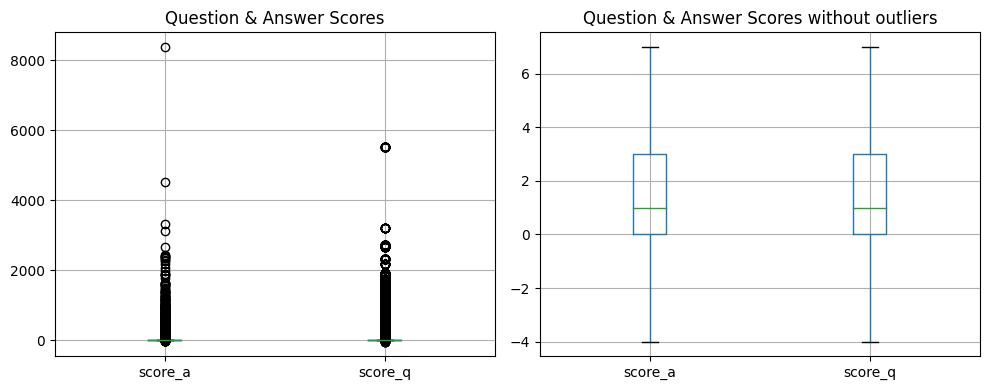

In [ ]:
# Plot q&a score distributions
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ax=axs[0]
df.boxplot(column=['score_a', 'score_q'], ax=ax)
ax.set_title('Question & Answer Scores')

ax=axs[1]
df.boxplot(column=['score_a', 'score_q'], showfliers=False, ax=ax)
ax.set_title('Question & Answer Scores without outliers')

fig.tight_layout()

- Answer and question scores have outliers
- Removing outliers, question and answer scores have similar distributions, with meadian scores at 1
- I will filter the data to exclude rows with an answer score < 3 to improve the quality of the dataset. This will maintain the top 25% of the data.

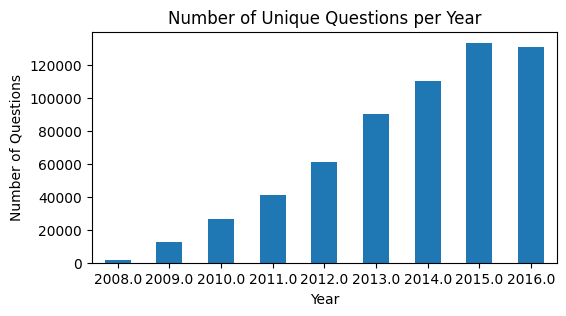

In [ ]:
# Plot distribution of questions per year
df.groupby(df.creationdate_q.dt.year)['id_q'].nunique().plot(kind='bar', figsize=(6,3))
df.groupby(df.creationdate_q.dt.year)['score_a'].mean().plot()
plt.title('Number of Unique Questions per Year')
plt.xlabel('Year')
plt.ylabel('Number of Questions')
plt.show()

- The number of questions in the data increases over time, with a peak in 2015

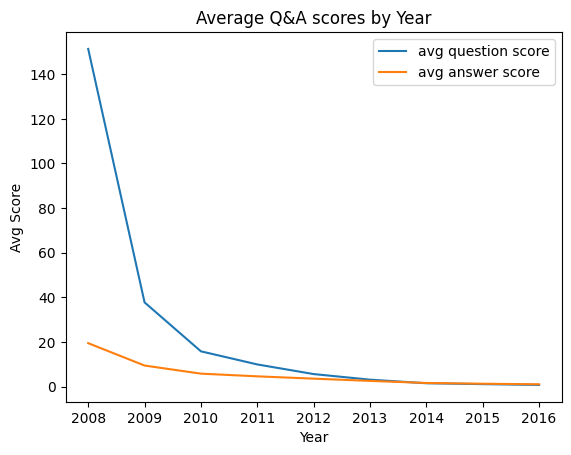

In [ ]:
# Plot avg question and answer scores by year
df.groupby(df.creationdate_q.dt.year)['score_q'].mean().plot(label='avg question score')
df.groupby(df.creationdate_q.dt.year)['score_a'].mean().plot(label='avg answer score')
plt.title('Average Q&A scores by Year')
plt.xlabel('Year')
plt.ylabel('Avg Score')
plt.legend()
plt.show()

- The highest average scores are in 2008-2009 which indicates that the high outlier scores are likely from the older data
- Average scores are fairly constant from 2013-2016

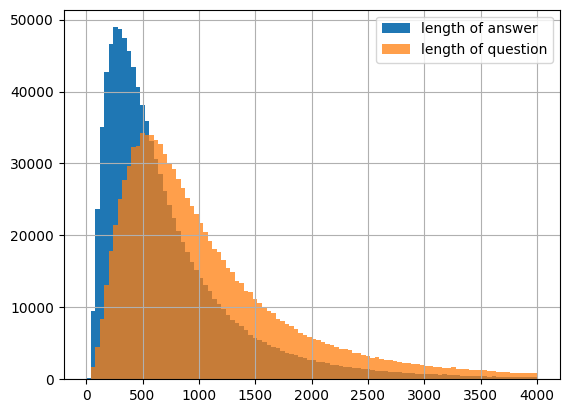

In [ ]:
# Plot the length of question and answers
df.body_a.str.len().hist(bins=100, range=(0,4000), label='length of answer')
df.body_q.str.len().hist(bins=100, range=(0,4000), alpha=.75, label='length of question')
plt.legend()
plt.show()

- Question length peaks around 500 characters, and is positively skewed
- Answer length peaks around 250 characters and is positively skewed

In [ ]:
# Compare mean/median of question and answer lengths
print(f'Median length of answer: {df.body_a.str.len().median()}')
print(f'Mean length of answer: {df.body_a.str.len().mean()}')
print(f'Max length of answer: {df.body_a.str.len().max()}')

print()
print(f'Median length of question: {df.body_q.str.len().median()}')
print(f'Mean length of question: {df.body_q.str.len().mean()}')
print(f'Max length of answer: {df.body_q.str.len().max()}')

Median length of answer: 544.0
Mean length of answer: 774.0262662568558
Mean length of answer: 33880.0

Median length of question: 880.0
Mean length of question: 1244.022996381612
Mean length of answer: 48242.0


**Number of answers per question**

In [ ]:
# Questions with multiple/one answers, answer score density
n_answers = df.groupby('id_q')['id_a'].nunique()

one_answ = df[(df.id_q.isin(n_answers[n_answers == 1].index) & (df.score_a < 20) & (df.score_a > 0))]
multi_answ = df[(df.id_q.isin(n_answers[n_answers > 1].index) & (df.score_a < 20) & (df.score_a > 0))]

In [ ]:
n_answers.describe()

count    607282.000000
mean          1.625475
std           1.381757
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          55.000000
Name: id_a, dtype: float64

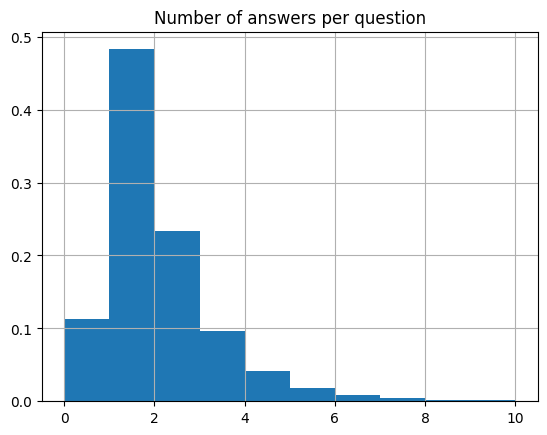

In [ ]:
# Plot number of answers per question
n_answers.hist(bins=10, range=(0,10), density=True)
plt.title('Number of answers per question')
plt.show()

- The majority of questions have 2 or 3 answers

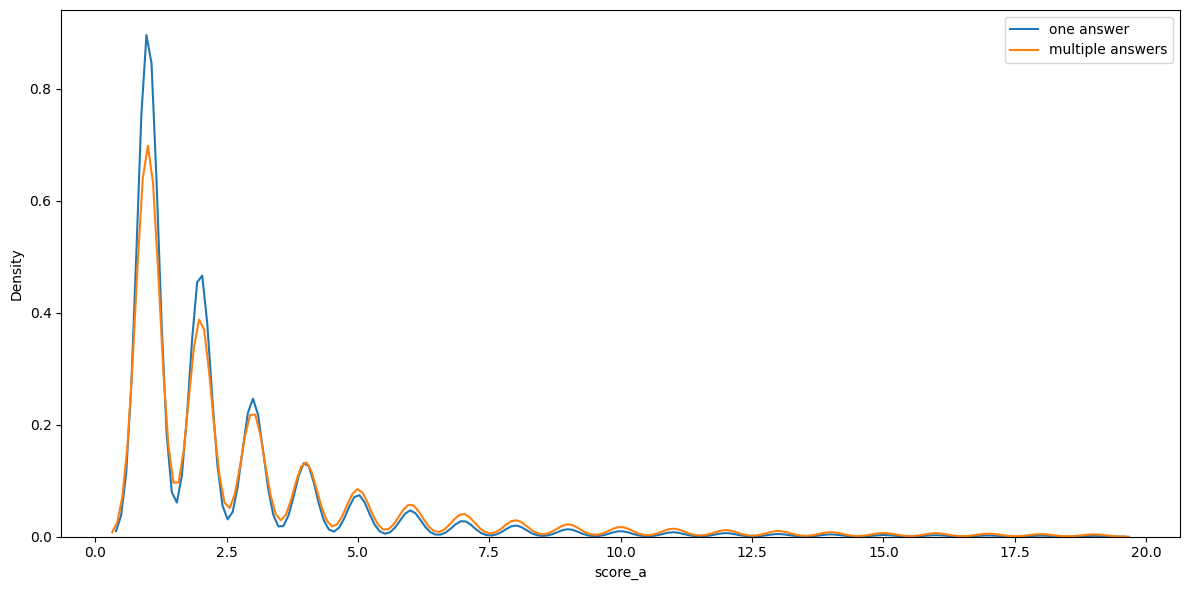

In [ ]:
# Plot the density of answer scores that had just one answer vs. multiple answers
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(one_answ.score_a, label='one answer', ax=ax)
sns.kdeplot(multi_answ.score_a, label='multiple answers', ax=ax)
ax.legend()
plt.tight_layout()
plt.show()

- This graph indicates that setting the minimum score threshold at 3 would lose some question/answers that are unique in the data

## Pre-processing

In [ ]:
df.shape

(1055167, 12)

- There are >1M rows in the data before pre-processing

### Missing values

In [ ]:
# Remove NAs
df.isna().sum()

id_q                   1
owneruserid_q      13600
creationdate_q         1
score_q                1
title                  1
body_q                 1
id_a               68045
owneruserid_a      73412
creationdate_a     68045
score_a            68045
body_a             68045
tag               132866
dtype: int64

- There are 68045 rows that are missing an answer, these can be dropped

In [ ]:
# Drop questions that have no answer
df_clean = df.dropna(subset=('id_a'))

In [ ]:
df_clean.shape

(987122, 12)

- There are 987122 rows after dropping missing values

### Normalization

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987122 entries, 0 to 1055161
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   id_q            987122 non-null  float64            
 1   owneruserid_q   973748 non-null  float64            
 2   creationdate_q  987122 non-null  datetime64[ns, UTC]
 3   score_q         987122 non-null  float64            
 4   title           987122 non-null  object             
 5   body_q          987122 non-null  object             
 6   id_a            987122 non-null  float64            
 7   owneruserid_a   981755 non-null  float64            
 8   creationdate_a  987122 non-null  datetime64[ns, UTC]
 9   score_a         987122 non-null  float64            
 10  body_a          987122 non-null  object             
 11  tag             858082 non-null  object             
dtypes: datetime64[ns, UTC](2), float64(6), object(4)
memory usage: 97.9+ MB

In [ ]:
# Function to remove html tags
def remove_tags(html):

    # parse html content
    soup = BeautifulSoup(html, "lxml")

    for data in soup(['style', 'script']):
        # Remove tags
        data.decompose()

    # return data by retrieving the tag content
    return ' '.join(soup.stripped_strings)

In [ ]:
# Remove html tags in questions
df_clean.body_q = df_clean['body_q'].apply(remove_tags)


<ipython-input-33-b9104bbf1ae3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.body_q = df_clean['body_q'].apply(remove_tags)


In [ ]:
# Remove html tags in answers
df_clean.body_a = df_clean['body_a'].apply(remove_tags)


<ipython-input-34-ecca9f958756>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.body_a = df_clean['body_a'].apply(remove_tags)


In [ ]:
# Create context features
df_clean.tag = df_clean.tag.fillna('')

#if you want to just have the title and answer in context
df_clean['context_w_title'] = df_clean.title + ' ' + df_clean.body_a
df_clean['context_w_quest'] = df_clean.body_q + ' ' + df_clean.body_a

<ipython-input-35-8c1f91d39e53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.tag = df_clean.tag.fillna('')
<ipython-input-35-8c1f91d39e53>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['context_w_title'] = df_clean.title + ' ' + df_clean.body_a
<ipython-input-35-8c1f91d39e53>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [ ]:
df_clean.head()

,id_q,owneruserid_q,creationdate_q,score_q,title,body_q,id_a,owneruserid_a,creationdate_a,score_a,body_a,tag,context_w_title,context_w_quest
0,469.0,147.0,2008-08-02 15:11:16+00:00,21.0,How can I find the full path to a font from it...,I am using the Photoshop's javascript API to f...,497.0,50.0,2008-08-02 16:56:53+00:00,4.0,open up a terminal (Applications->Utilities->T...,"osx, fonts, photoshop",How can I find the full path to a font from it...,I am using the Photoshop's javascript API to f...
1,469.0,147.0,2008-08-02 15:11:16+00:00,21.0,How can I find the full path to a font from it...,I am using the Photoshop's javascript API to f...,518.0,153.0,2008-08-02 17:42:28+00:00,2.0,I haven't been able to find anything that does...,"osx, fonts, photoshop",How can I find the full path to a font from it...,I am using the Photoshop's javascript API to f...
2,469.0,147.0,2008-08-02 15:11:16+00:00,21.0,How can I find the full path to a font from it...,I am using the Photoshop's javascript API to f...,3040.0,457.0,2008-08-06 03:01:23+00:00,12.0,Unfortunately the only API that isn't deprecat...,"osx, fonts, photoshop",How can I find the full path to a font from it...,I am using the Photoshop's javascript API to f...
3,469.0,147.0,2008-08-02 15:11:16+00:00,21.0,How can I find the full path to a font from it...,I am using the Photoshop's javascript API to f...,195170.0,745.0,2008-10-12 07:02:40+00:00,1.0,There must be a method in Cocoa to get a list ...,"osx, fonts, photoshop",How can I find the full path to a font from it...,I am using the Photoshop's javascript API to f...
4,502.0,147.0,2008-08-02 17:01:58+00:00,27.0,Get a preview JPEG of a PDF on Windows?,I have a cross-platform (Python) application w...,536.0,161.0,2008-08-02 18:49:07+00:00,9.0,You can use ImageMagick's convert utility for ...,"windows, image, pdf",Get a preview JPEG of a PDF on Windows? You ca...,I have a cross-platform (Python) application w...


In [ ]:
# Check that all html elements were removed
df_clean.context_w_quest[0]

"I am using the Photoshop's javascript API to find the fonts in a given PSD. Given a font name returned by the API, I want to find the actual physical font file that that font name corresponds to on the disc. This is all happening in a python program running on OSX so I guess I'm looking for one of: Some Photoshop javascript A Python function An OSX API that I can call from python open up a terminal (Applications->Utilities->Terminal) and type this in: locate InsertFontHere This will spit out every file that has the name you want. Warning: there may be alot to wade through."

In [ ]:
df_clean.shape

(987122, 14)

In [ ]:
# Save the pre-processed output to file
df_clean.to_csv('/content/drive/MyDrive/TripleTen/Externship_Dataspark/Datasets/python_q_a_clean.csv', index=False)


### Filtering

In [73]:
df_clean = pd.read_csv('/Users/laceymalarky/git_projects/TripleTen_projects/TripleTen_projects/externship-dataspeak/data/python_q_a_clean.csv')


In [74]:
# Remove newline characters, code arrows
#df_clean.body_q = df_clean.body_q.replace(r'\n',' ', regex=True)
#df_clean.body_a = df_clean.body_a.replace(r'\n',' ', regex=True)

df_clean.body_q = df_clean.body_q.replace(r'>>>>',' ', regex=True)
df_clean.body_a = df_clean.body_a.replace(r'>>>>',' ', regex=True)

df_clean.body_q = df_clean.body_q.replace(r'>>>',' ', regex=True)
df_clean.body_a = df_clean.body_a.replace(r'>>>',' ', regex=True)

In [75]:
# Drop any answer NaNs (some additional exist after removing html tags)
df_clean = df_clean.dropna(subset=['body_a'])
df_clean.isna().sum()

id_q                    0
owneruserid_q       13374
creationdate_q          0
score_q                 0
title                   0
body_q                  1
id_a                    0
owneruserid_a        5367
creationdate_a          0
score_a                 0
body_a                  0
tag                129040
context_w_title         0
context_w_quest         0
dtype: int64

#### Filter on score

In [76]:
df_clean.shape

(987119, 14)

- There are 987119 rows after removing missing answers again

In [77]:
# Remove any answers with a score less than 3
df_clean = df_clean[df_clean.score_a >= 3].reset_index(drop=True)
df_clean.shape

(247516, 14)

- There are 247516 rows after filtering on score

In [78]:
# Filter data to contain only one answer per question, the answer with the highest score
idx = df_clean.groupby('id_q')['score_a'].transform('max') == df_clean['score_a']
df2 = df_clean[idx]
print(df2.shape)
df2.head()

(183206, 14)


,id_q,owneruserid_q,creationdate_q,score_q,title,body_q,id_a,owneruserid_a,creationdate_a,score_a,body_a,tag,context_w_title,context_w_quest
1,469.0,147.0,2008-08-02 15:11:16+00:00,21.0,How can I find the full path to a font from it...,I am using the Photoshop's javascript API to f...,3040.0,457.0,2008-08-06 03:01:23+00:00,12.0,Unfortunately the only API that isn't deprecat...,"osx, fonts, photoshop",How can I find the full path to a font from it...,I am using the Photoshop's javascript API to f...
3,502.0,147.0,2008-08-02 17:01:58+00:00,27.0,Get a preview JPEG of a PDF on Windows?,I have a cross-platform (Python) application w...,7090.0,13.0,2008-08-10 08:08:33+00:00,25.0,ImageMagick delegates the PDF->bitmap conversi...,"windows, image, pdf",Get a preview JPEG of a PDF on Windows? ImageM...,I have a cross-platform (Python) application w...
4,535.0,154.0,2008-08-02 18:43:54+00:00,40.0,Continuous Integration System for a Python Cod...,I'm starting work on a hobby project with a py...,538.0,156.0,2008-08-02 18:56:56+00:00,23.0,One possibility is Hudson. It's written in Ja...,"continuous-integration, extreme-programming",Continuous Integration System for a Python Cod...,I'm starting work on a hobby project with a py...
10,594.0,116.0,2008-08-03 01:15:08+00:00,25.0,cx_Oracle: How do I iterate over a result set?,There are several ways to iterate over a resul...,595.0,116.0,2008-08-03 01:17:36+00:00,25.0,The canonical way is to use the built-in curso...,"sql, database, oracle, cx-oracle",cx_Oracle: How do I iterate over a result set?...,There are several ways to iterate over a resul...
16,683.0,199.0,2008-08-03 13:19:16+00:00,28.0,Using 'in' to match an attribute of Python obj...,I don't remember whether I was dreaming or not...,57833.0,4702.0,2008-09-11 22:42:14+00:00,29.0,Using a list comprehension would build a tempo...,"arrays, iteration",Using 'in' to match an attribute of Python obj...,I don't remember whether I was dreaming or not...


- There are 183206 rows after filtring to keep the highest scored answer per question

In [79]:
df2.id_q.count() - df2.id_q.nunique()

6100

- There are 6100 questions with multiple answers with the same highest score thath are retained in the data

#### Filter on length

In [80]:
print(f'Median length of answer: {df2.body_a.str.len().median()}')
print(f'Mean length of answer: {df2.body_a.str.len().mean()}')
print(f'Max length of answer: {df2.body_a.str.len().max()}')

print()
print(f'Median length of question: {df2.body_q.str.len().median()}')
print(f'Mean length of question: {df2.body_q.str.len().mean()}')
print(f'Max length of question: {df2.body_q.str.len().max()}')


Median length of answer: 492.0
Mean length of answer: 738.9217820377062
Max length of answer: 27298

Median length of question: 659.0
Mean length of question: 951.015223300547
Max length of question: 30209


- The long answers and questions will be removed to help improve model performance

In [81]:
# Count number of words in answer
df2['wc_a'] = df2.body_a.apply(lambda n: len(n.split()))
df2.wc_a.describe()

/var/folders/61/dg8q01vd63s1rx311g530r400000gn/T/ipykernel_9118/2025886013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['wc_a'] = df2.body_a.apply(lambda n: len(n.split()))


count    183206.000000
mean        108.750161
std         122.941248
min           1.000000
25%          40.000000
50%          74.000000
75%         134.000000
max        4064.000000
Name: wc_a, dtype: float64

In [82]:
# Count number of words in question
df2['wc_q'] = df2.body_q.apply(lambda n: len(n.split()))
df2.wc_q.describe()

/var/folders/61/dg8q01vd63s1rx311g530r400000gn/T/ipykernel_9118/3860598847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['wc_q'] = df2.body_q.apply(lambda n: len(n.split()))


count    183206.000000
mean        133.118375
std         122.285564
min           1.000000
25%          65.000000
50%         103.000000
75%         162.000000
max        4355.000000
Name: wc_q, dtype: float64

- Mean length of answer: 108 words
- Mean length of question: 133 words

In [83]:
# Filter out answers and questions with word count > 150
df2 = df2[(df2.wc_a <=150) & (df2.wc_q <=150)].reset_index(drop=True)

In [84]:
df2.shape

(108917, 16)

- There are 108563 rows after filtering on word count

In [85]:
print(f'Median length of answer: {df2.body_a.str.len().median()}')
print(f'Mean length of answer: {df2.body_a.str.len().mean()}')
print(f'Max length of answer: {df2.body_a.str.len().max()}')

print()
print(f'Median length of question: {df2.body_q.str.len().median()}')
print(f'Mean length of question: {df2.body_q.str.len().mean()}')
print(f'Max length of question: {df2.body_q.str.len().max()}')


Median length of answer: 366.0
Mean length of answer: 418.2421017839272
Max length of answer: 15459

Median length of question: 489.0
Mean length of question: 531.2604184837996
Max length of question: 22198


In [86]:
df2.body_a[df2.body_a.str.len() == 15459].values

array(['Starting with imgData = b\'iVBORw0KGgoAAAANSUhEUgAABoIAAAaCCAYAAAABZu+EAAAqOElEQVR42uzBAQEAAACAkP6v7ggK\\nAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA\\nAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA\\nAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA\\nAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA\\nAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA\\nAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA\\nAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA\\nAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA\\nAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA\\nAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA\\nAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA\\nAAAAAAAAAAAAAAAAA

- Need to remove the records with high character counts, example above

In [87]:
# Filter out answers and questions with character count > 3000
df2 = df2[(df2.body_q.str.len() < 3000) & (df2.body_a.str.len() < 3000)].reset_index(drop=True)

In [88]:
df2.shape

(108898, 16)

- Filtered out answers and questions longer than 150 words (to improve model performance)
- Filtered out answers and quesitons with character count greater than 3000 (ex these are very long strings of characters that are not words and should be removed)- There are 108544 rows after filtering out questions and answers on character counts

In [89]:
print(f'Median length of answer: {df2.body_a.str.len().median()}')
print(f'Mean length of answer: {df2.body_a.str.len().mean()}')
print(f'Max length of answer: {df2.body_a.str.len().max()}')
print()
print(f'Median length of question: {df2.body_q.str.len().median()}')
print(f'Mean length of question: {df2.body_q.str.len().mean()}')
print(f'Max length of question: {df2.body_q.str.len().max()}')

Median length of answer: 366.0
Mean length of answer: 417.9697974251134
Max length of answer: 2574

Median length of question: 489.0
Mean length of question: 530.3014655916546
Max length of question: 2957


In [90]:
df2 = df2.drop(columns=['owneruserid_q', 'creationdate_q', 'owneruserid_a', 'creationdate_a', 'tag'])

In [91]:
df2.columns

Index(['id_q', 'score_q', 'title', 'body_q', 'id_a', 'score_a', 'body_a',
       'context_w_title', 'context_w_quest', 'wc_a', 'wc_q'],
      dtype='object')

In [92]:
df2.columns = ['id_q', 'score_q', 'title', 'question', 'id_a', 'score_a', 'answer_text', 'context_w_title', 'context_w_quest', 'wc_a', 'wc_q']

In [94]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108898 entries, 0 to 108897
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id_q             108898 non-null  float64
 1   score_q          108898 non-null  float64
 2   title            108898 non-null  object 
 3   question         108898 non-null  object 
 4   id_a             108898 non-null  float64
 5   score_a          108898 non-null  float64
 6   answer_text      108898 non-null  object 
 7   context_w_title  108898 non-null  object 
 8   context_w_quest  108898 non-null  object 
 9   wc_a             108898 non-null  int64  
 10  wc_q             108898 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 9.1+ MB


### Export

In [99]:
# Write to drive
df2.to_csv('/Users/laceymalarky/git_projects/TripleTen_projects/TripleTen_projects/externship-dataspeak/data/python_q_a_clean_score3_AandQwc150.csv')